In [1]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
sns.set_theme()

### Helper functions

In [2]:
def sample_model(model):
    with model:
        trace = pm.sample()
    return trace

def sample_models(models):
    traces = []
    for model in models:
        traces.append(sample_model(model))
    return traces

def plots(traces, var_names):
    if isinstance(var_names, str):
        var_names = [var_names]
    for trace in traces:
        pm.plot_trace(trace)    
    for trace in traces:
        pm.plot_forest(trace, var_names=var_names, combined=True)

### Data

In [3]:
J = 8
school = ["A", "B", "C", "D", "E", "F", "G", "H"]
y = np.array([28.39,  7.94, -2.75,  6.82, -0.64,  0.63, 18.01, 12.16])
sigma = np.array([14.9, 10.2, 16.3, 11.0,  9.4, 11.4, 10.4, 17.6])

mu_0 = np.mean(y)

print(np.mean(y), np.mean(sigma), np.mean(sigma) / np.sqrt(8))

8.82 12.65 4.472450391004913


### A proposed prior distribution on tau

(0.0, 50.0)

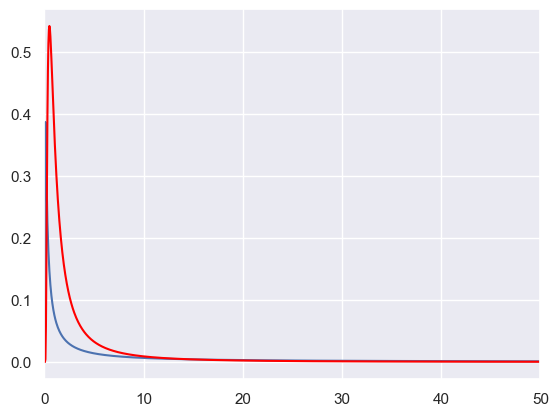

In [4]:
x_range = np.linspace(0, 50, 1000)
fig, ax = plt.subplots()
# pm.plot_dist(pm.draw(pm.InverseGamma.dist(alpha=1, beta=10), draws=1000), color="red", ax=ax)
plt.plot(x_range, scipy.stats.invgamma.pdf(x_range, a=.1, scale=.1))
plt.plot(x_range, scipy.stats.invgamma.pdf(x_range, a=1, scale=1), color="red")

ax.set_xlim(0,50)

### Model 1: No pooling - Independent Estimate for Each School

$$ \theta_j \sim N(0, 100) $$
$$ y_i \sim N(\theta_j, \sigma^2_j) $$

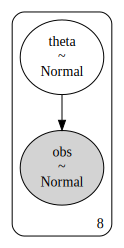

In [5]:
with pm.Model() as m1:
    theta = pm.Normal("theta", mu=0, sigma=100, shape=J)
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

pm.model_to_graphviz(m1)

### Model 2: Complete Pooling - All Schools draw from the same distribution with known variance sigma_j

$$ \theta \sim N(0, 100) $$
$$ y_i \sim N(\theta, \sigma^2_j) $$

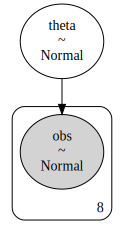

In [6]:
with pm.Model() as m2:
    theta = pm.Normal("theta", mu=0, sigma=100)
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)
pm.model_to_graphviz(m2)

### Model 3: The Heirarchical Model

$$ \tau \sim InvGamma(1, 10) $$
$$ \mu \sim N(0, 100) $$

$$ \theta_j \sim N(\mu, \tau) $$

$$ y_i \sim N(\theta_j, \sigma^2_j) $$


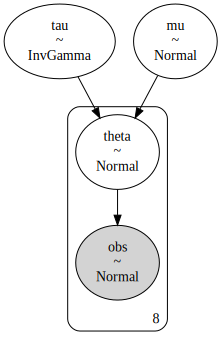

In [7]:
with pm.Model() as m3:
    tau = pm.InverseGamma("tau", alpha=1, beta=10)
    mu = pm.Normal("mu", mu=0, sigma=100)
    
    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J)

    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

pm.model_to_graphviz(m3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, mu, theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5802, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


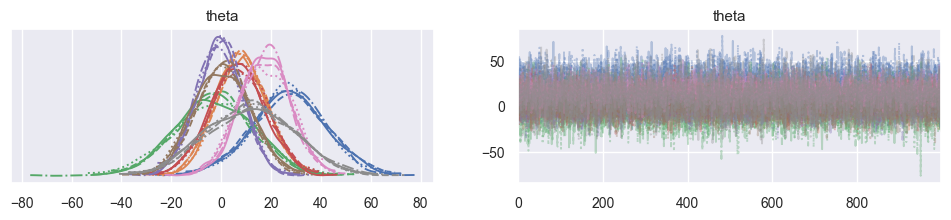

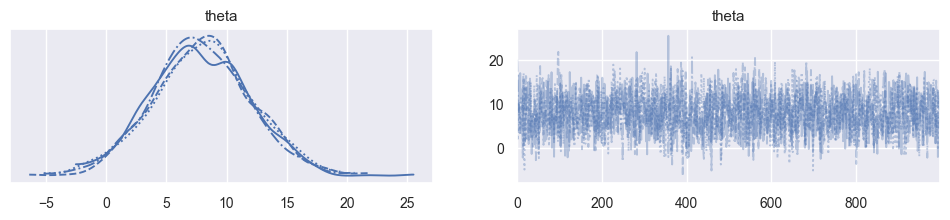

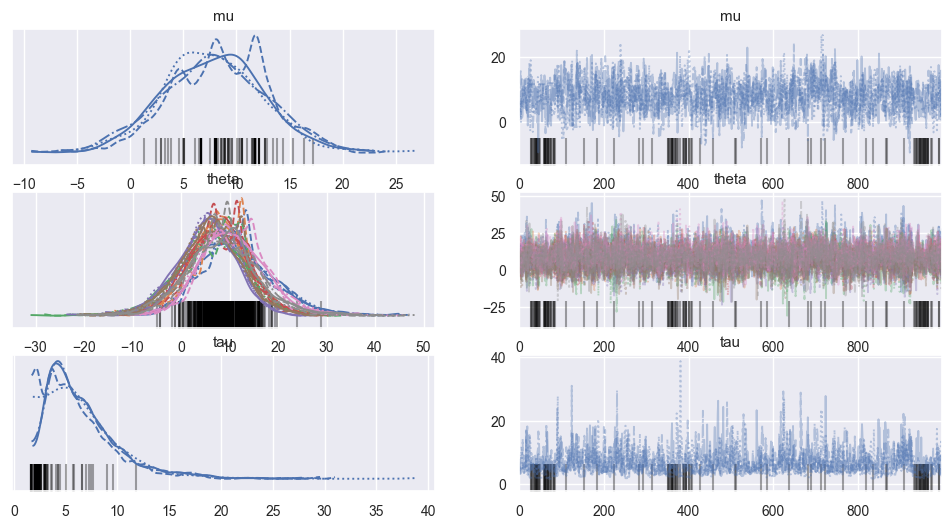

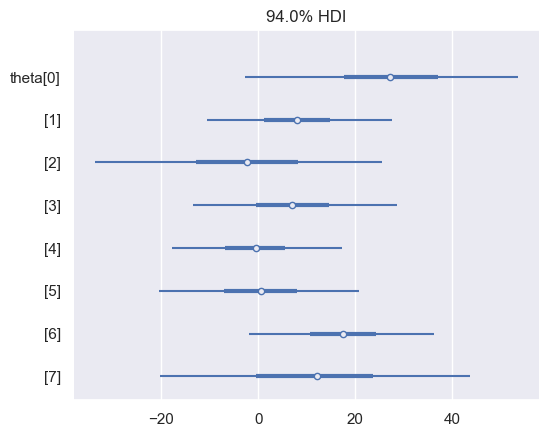

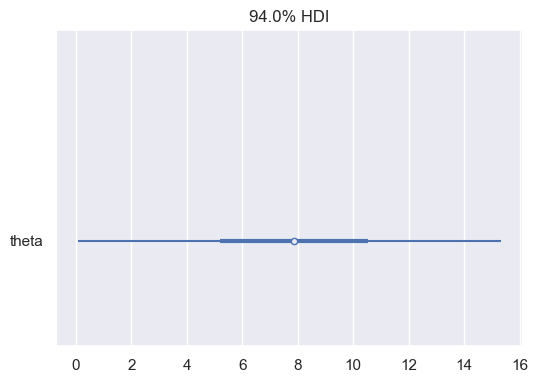

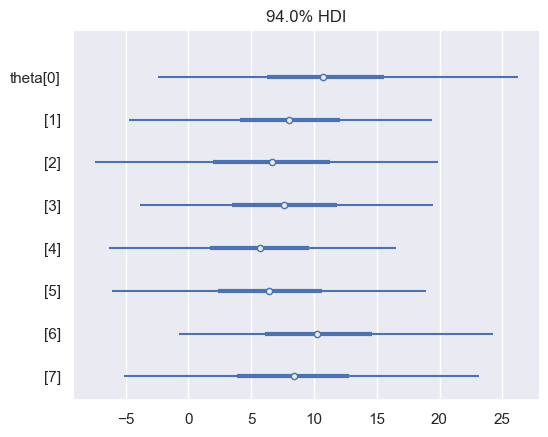

In [8]:
traces = sample_models([m1, m2, m3])
plots(traces, var_names=["theta"])

### Model 3b: Non-centered Heirarchical

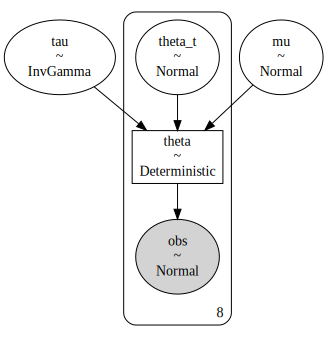

In [9]:
with pm.Model() as m3b:
    
    tau = pm.InverseGamma("tau", alpha=1, beta=10)
    mu = pm.Normal("mu", mu=0, sigma=100)

    theta_t = pm.Normal("theta_t", mu=0, sigma=1, shape=J)
    theta = pm.Deterministic("theta", mu + theta_t * tau)

    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

pm.model_to_graphviz(m3b)

In [10]:
trace_m3b = sample_model(m3b)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, mu, theta_t]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


### A non-centered parameterization will help with chain divergences

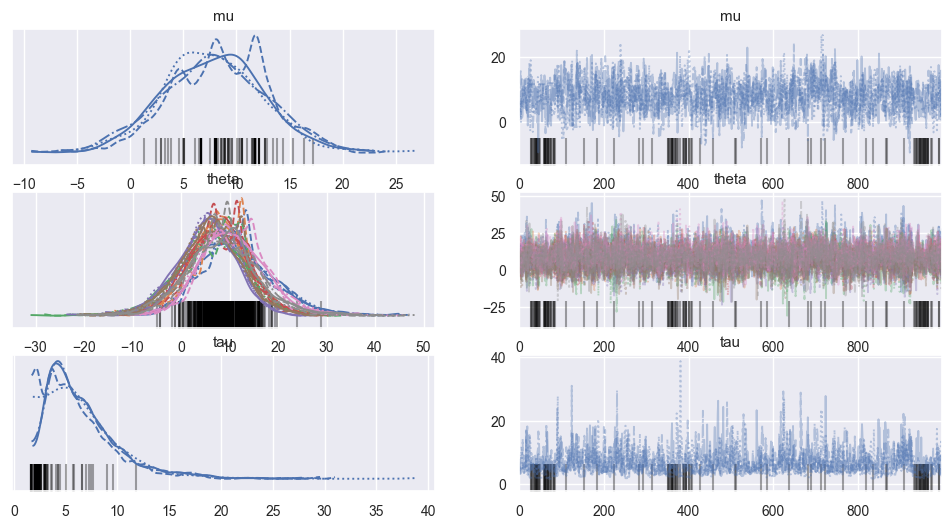

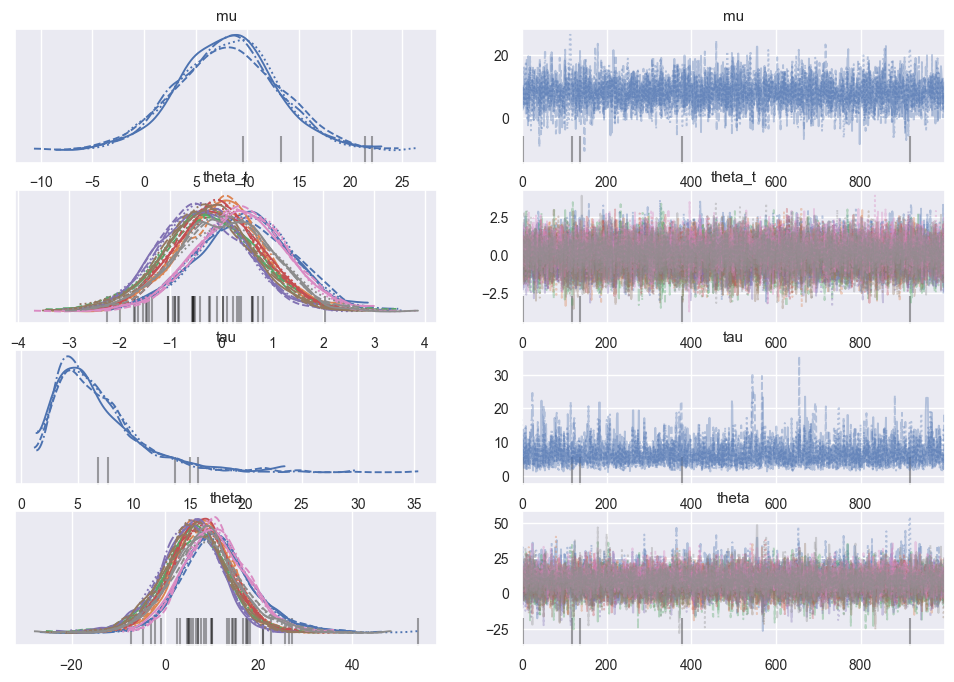

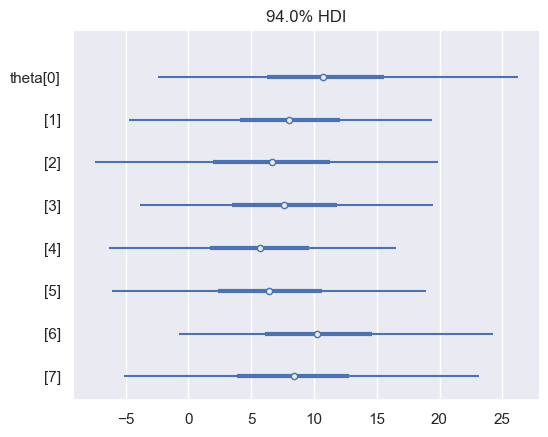

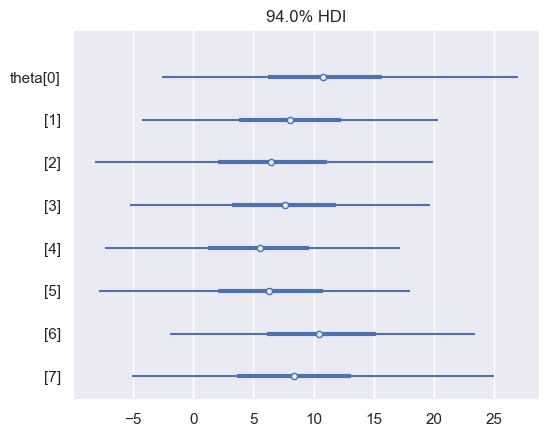

In [11]:
plots([traces[2], trace_m3b], var_names="theta")

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

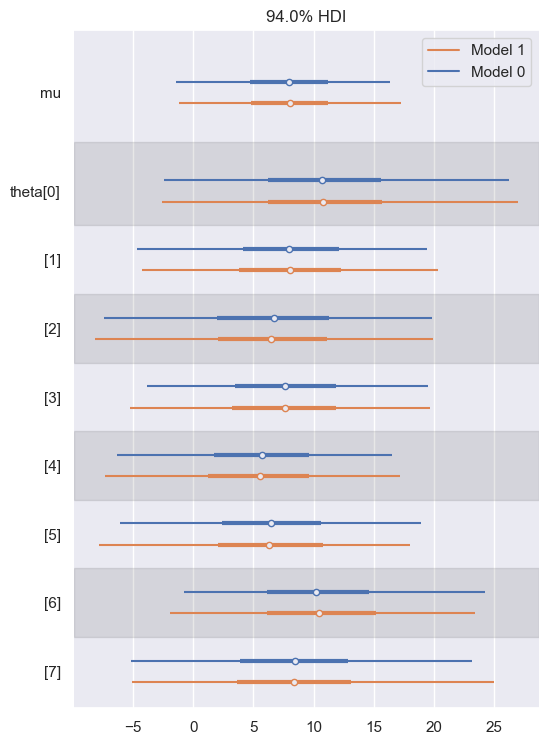

In [12]:
pm.plot_forest([traces[2], trace_m3b], var_names=["mu", "theta"], combined=True)